In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random as rn

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [40]:
aids = pd.read_csv('data/AIDS_Classification.csv')

In [41]:
aids.drop(columns={'z30', 'treat','str2', 'cd420','cd820'}, inplace=True)

In [42]:
class DataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, original_columns):
        self.transformer = transformer
        self.original_columns = original_columns
    
    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        X_transformed = self.transformer.transform(X)
        if not isinstance(X_transformed, pd.DataFrame):
            X_transformed = pd.DataFrame(X_transformed, columns=self.get_feature_names_out())
        
        original_data = X[self.original_columns]
        
        X_final = pd.concat([original_data.reset_index(drop=True), X_transformed.reset_index(drop=True)], axis=1)
        return X_final
    
    def get_feature_names_out(self):
        return self.transformer.get_feature_names_out()

In [43]:
cols_to_scale = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd80']
cols_to_one_hot = ['trt', 'strat']
orginal_columns = [col for col in aids.columns if col not in (cols_to_scale + cols_to_one_hot)]

preprocessor = ColumnTransformer(transformers = [
    ('numerical', StandardScaler(), cols_to_scale),
    ('one_hot', OneHotEncoder(drop='first'), cols_to_one_hot)
])

pipe = Pipeline(steps = [
                ('preprocessor', DataFrameTransformer(preprocessor, orginal_columns)),
])

# joblib.dump(pipe, 'models/data_transformer.pkl')

aids_t = pipe.fit_transform(aids)

aids_t.to_csv('data/aids_t.csv')

In [44]:
def metrics(model, X_train, y_train, X_test, y_test):
    # Przewidywanie wartości na zbiorze treningowym
    print('Metryki dla zbioru treningowego')
    print('-' * 50)

    y_pred = model.predict(X_train)

    # Obliczanie metryk
    accuracy = accuracy_score(y_train, y_pred)
    conf_matrix = confusion_matrix(y_train, y_pred)
    class_report = classification_report(y_train, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

    print('Metryki dla zbioru testowego')
    print('-' * 50)

    # Przewidywanie wartości na zbiorze testowym
    y_pred = model.predict(X_test)

    # Obliczanie metryk
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

In [45]:
X = aids_t.drop(columns=['infected'])
y = aids_t['infected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Tworzenie modelu lasu losowego
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)

# Trenowanie modelu
clf1.fit(X_train, y_train)

# Dokonanie predykcji na zbiorze testowym
y_pred = clf1.predict(X_test)

metrics(clf1, X_train, y_train, X_test, y_test)

Metryki dla zbioru treningowego
--------------------------------------------------
Accuracy: 1.0
Confusion Matrix:
 [[1213    0]
 [   0  391]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1213
           1       1.00      1.00      1.00       391

    accuracy                           1.00      1604
   macro avg       1.00      1.00      1.00      1604
weighted avg       1.00      1.00      1.00      1604

Metryki dla zbioru testowego
--------------------------------------------------
Accuracy: 0.8672897196261682
Confusion Matrix:
 [[383  22]
 [ 49  81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       405
           1       0.79      0.62      0.70       130

    accuracy                           0.87       535
   macro avg       0.84      0.78      0.81       535
weighted avg       0.86      0.87      0.86       535



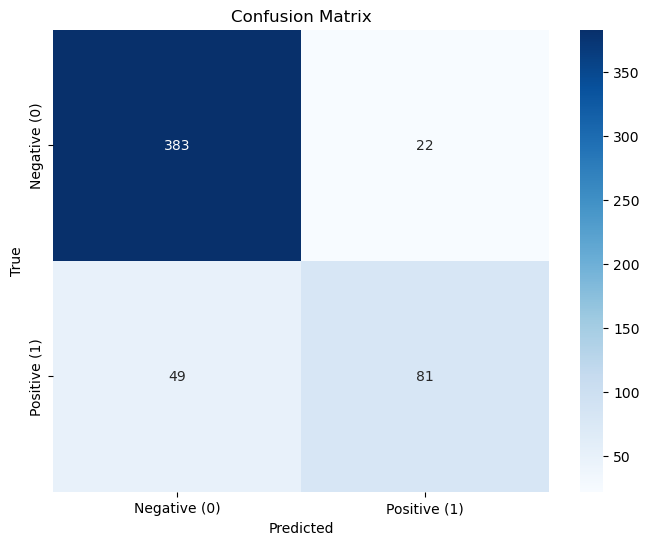

In [46]:
y_pred = clf1.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

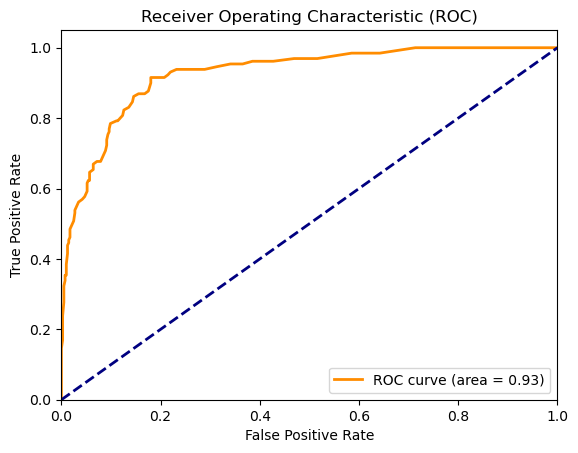

In [47]:
y_pred_prob = clf1.predict_proba(X_test)[:,1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [48]:
# Tworzenie modelu lasu losowego
clf2 = RandomForestClassifier(n_estimators=200, random_state=42)

# Trenowanie modelu
clf2.fit(X_train, y_train)

# Dokonanie predykcji na zbiorze testowym
y_pred = clf2.predict(X_test)

metrics(clf2, X_train, y_train, X_test, y_test)

Metryki dla zbioru treningowego
--------------------------------------------------
Accuracy: 1.0
Confusion Matrix:
 [[1213    0]
 [   0  391]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1213
           1       1.00      1.00      1.00       391

    accuracy                           1.00      1604
   macro avg       1.00      1.00      1.00      1604
weighted avg       1.00      1.00      1.00      1604

Metryki dla zbioru testowego
--------------------------------------------------
Accuracy: 0.8710280373831776
Confusion Matrix:
 [[385  20]
 [ 49  81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       405
           1       0.80      0.62      0.70       130

    accuracy                           0.87       535
   macro avg       0.84      0.79      0.81       535
weighted avg       0.87      0.87      0.87       535



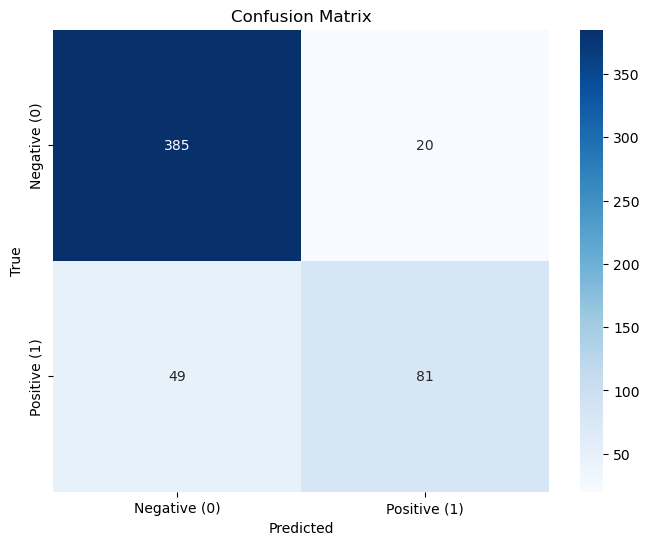

In [49]:
y_pred = clf2.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Definicja etykiet klas
class_labels = ['Negative (0)', 'Positive (1)']

# Wyświetlenie macierzy pomyłek z opisami
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

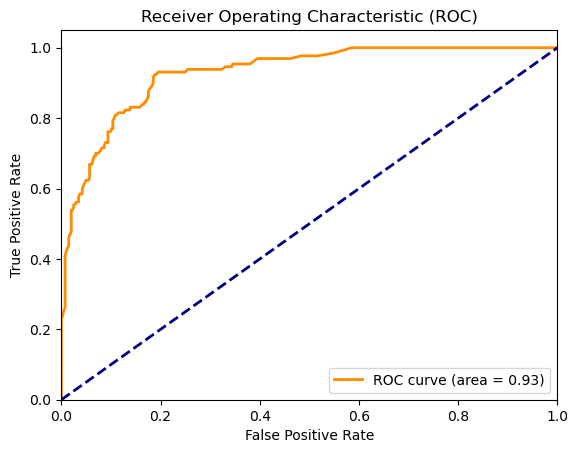

In [50]:
y_pred_prob = clf2.predict_proba(X_test)[:,1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()